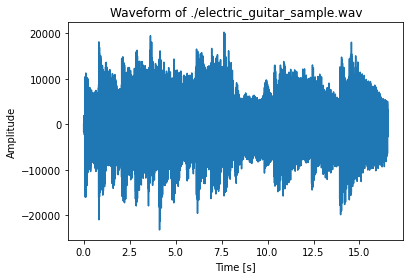

In [11]:
# open wave file and plot as input waveform

import wave
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

file_path = "./electric_guitar_sample.wav"

with wave.open(file_path, 'r') as wave_file:
    # get the number of frames
    n_frames = wave_file.getnframes()
    # read the frames
    frames = wave_file.readframes(n_frames)
    # convert frames to integers
    frames = np.frombuffer(frames, dtype=np.int16)

    # get the frame rate
    frame_rate = wave_file.getframerate()
    # get the time values for the x axis
    time = np.linspace(0, len(frames) / frame_rate, num=len(frames))

    # plot the waveform
    plt.figure()
    plt.plot(time, frames, label='Waveform')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.title('Waveform of ' + file_path)
    plt.show()


In [2]:
#playback origianl waveform using pyaudio
import pyaudio

# set up the audio stream
p = pyaudio.PyAudio()
stream = p.open(format=pyaudio.paInt16, channels=1, rate=frame_rate, output=True)

# play the audio
stream.write(frames.tobytes())


In [12]:
# save frames to .wav file

wavfile.write('outputs/original.wav', frame_rate, frames)

FileNotFoundError: [Errno 2] No such file or directory: 'outputs/original.wav'

# Distortion Algorithm

In [2]:
def distort(waveform: np.array, threshold: int, clip_factor: float) -> list:
    """Distort the waveform by clipping the values above the threshold and below the negative threshold and softening the clipped values."""
    # This function will be replaced by HLS code
    distorted_waveform = waveform

    # apply clipping
    distorted_waveform = np.where(distorted_waveform > threshold, (distorted_waveform - threshold) * clip_factor + threshold, distorted_waveform)
    distorted_waveform = np.where(distorted_waveform <  -threshold, (distorted_waveform - threshold) * clip_factor - threshold, distorted_waveform)
    return distorted_waveform
    
    
    

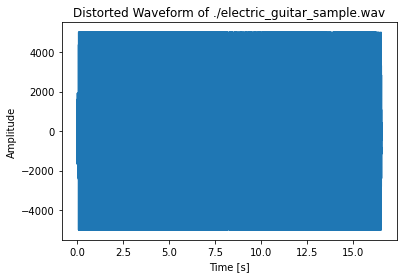

In [4]:
distored_frames = frames # make a copy of the original waveform

threshold = 5000 # this is the amplitude that will start the audio clipping
clip_factor = 0 # this is the factor that will soften the clipped audio

distored_frames = distort(distored_frames, threshold, clip_factor)
# print(type(distored_frames))
# print(f"Distored {distored_frames[:10]}")

# plot the waveform
plt.figure()
plt.plot(time, distored_frames, label='Waveform')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Distorted Waveform of ' + file_path)
plt.show()


/usr/local/share/pynq-venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


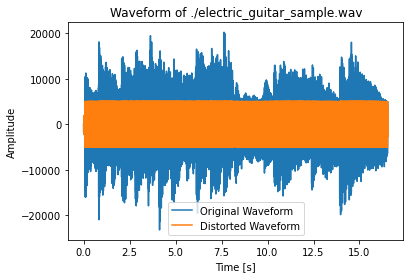

In [6]:
#plot frames and distored frames together to show the difference
plt.figure()
plt.plot(time, frames, label='Original Waveform')
plt.plot(time, distored_frames, label='Distorted Waveform')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Waveform of ' + file_path)
plt.legend()
plt.show()


In [7]:
#playback distorted waveform using pyaudio
import pyaudio
# NOTE THIS IS NOT SUPPORTED ON PYNQ BOARD

# set up the audio stream
p = pyaudio.PyAudio()
stream = p.open(format=pyaudio.paInt16, channels=1, rate=frame_rate, output=True)
# play the audio
stream.write(distored_frames.tobytes())



ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1334:(snd_func_refer) error evaluating name
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5701:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM sysdefault
ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_concat returned error: No

OSError: [Errno -9996] Invalid output device (no default output device)

# Compression Algorithm

In [8]:
# Amplitude detection used in compression algorithm

def detect_amplitude(waveform: np.array) -> list:
    """Returns a np.array of equal lenght corresponding to the amplitude of the waveform at that point."""
    # This function will be replaced by HLS code
    rectified_signal = np.abs(waveform)

    # now apply a low pass filter to the rectified signal to envelop detect
    filter_length = frame_rate // 5 # frame rate over lowest frequency
    filter = np.ones(filter_length) / filter_length # create a filter which will just average the signal over the filter length
    envelope = np.convolve(rectified_signal, filter, mode='same') # convolve filter with signal
    #amplify to match amplitude
    envelope = envelope * 3
    return envelope


In [ ]:
# plot the envelope of the waveform with the waveform
#on pynq board, userwarning will be generated but plot will still be generated after a long time
plt.figure()
plt.plot(time, frames, label='Waveform')
plt.plot(time, detect_amplitude(frames), label='Envelope')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Envelope of ' + file_path)
plt.legend()
plt.show()


/usr/local/share/pynq-venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


In [ ]:
# compression algorithm!

def compress(waveform: np.array, min_threshold: int, max_threshold: int, compression_factor: int) -> list:
    """Compress the waveform by reducing the amplitude of the values above the threshold by the given ratio."""
    # This function will be replaced by HLS code
    envelope = detect_amplitude(waveform)
    compressed_waveform = waveform
    gained_waveform = np.where(np.abs(waveform) < min_threshold,
                               np.sign(waveform) * (np.abs(waveform) - min_threshold) * compression_factor + min_threshold,
                               waveform)
    attenuated_waveform = np.where(np.abs(waveform) > max_threshold,
                               np.sign(waveform) * (np.abs(waveform) - max_threshold) / compression_factor + max_threshold,
                               waveform)
    # apply compression
    compressed_waveform = np.where(envelope > max_threshold, attenuated_waveform, compressed_waveform)
    compressed_waveform = np.where(envelope < min_threshold, gained_waveform, compressed_waveform)
    return compressed_waveform

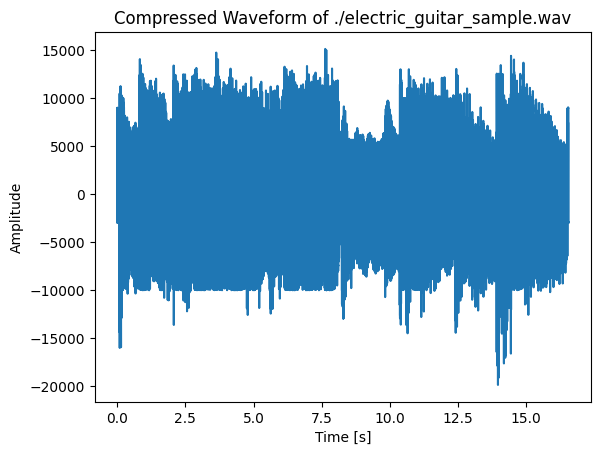

In [ ]:
# plot the compressed waveform
compressed_frames = compress(frames, 3000, 10000, 2)
plt.figure()
plt.plot(time, compressed_frames, label='Waveform')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Compressed Waveform of ' + file_path)
plt.show()


In [ ]:
# # playback compressed waveform
# #playback distorted waveform using pyaudio
# import pyaudio

# # set up the audio stream
# p = pyaudio.PyAudio()
# stream = p.open(format=pyaudio.paInt16, channels=1, rate=frame_rate, output=True)
# # play the audio
# stream.write(compressed_frames.tobytes())
